# Real-time Audio Processing Testing Notebook

This notebook demonstrates and tests the audio processing system with faster-whisper integration.

In [6]:
!apt-get update && apt-get install -y portaudio19-dev python3-pyaudio

!brew install portaudio

# Install required packages
!pip install faster-whisper webrtcvad numpy websockets torch matplotlib sounddevice scipy pyaudio

zsh:1: command not found: apt-get
To reinstall 19.7.0, run:
  brew reinstall portaudio


In [4]:
!pip install gtts pydub

  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)


In [3]:
import base64
import numpy as np
from collections import deque
from typing import Optional, List, Dict
import webrtcvad
import wave
import json
from gtts import gTTS
import torch
from faster_whisper import WhisperModel
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import asyncio
import websockets
import queue
import threading
import time
from gtts import gTTS
from pydub import AudioSegment
import io

## 1. Test Audio Recording

In [4]:
test_script = "                                   Technology is evolving rapidly, shaping the way we communicate, learn, and entertain ourselves. Every day, new innovations make it easier to stay connected, access vast information, and engage with diverse cultures from around the globe. Artificial intelligence, for instance, has revolutionized industries by enhancing automation, predictive capabilities, and personalization. Yet, as these advancements continue, they raise ethical and social considerations about privacy, equity, and the future of work. In this era of digital transformation, finding a balance between progress and responsibility remains essential."

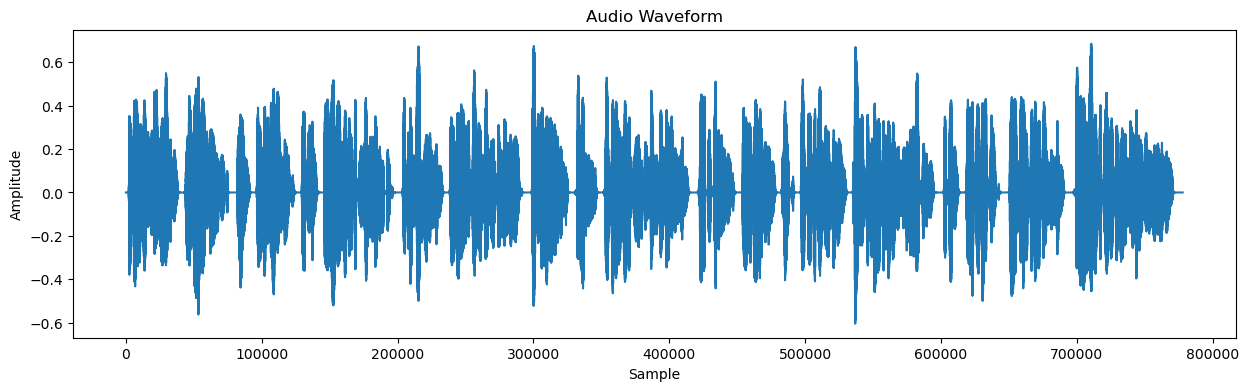

In [5]:
def create_text_audio_data(text="i wanted to know about"):
    """
    Generate audio data for the given text and return it as a NumPy array.
    """
    # Generate TTS audio and save it in-memory
    tts = gTTS(text=text, lang='en')
    audio_io = io.BytesIO()
    tts.write_to_fp(audio_io)
    audio_io.seek(0)

    # Load audio data using pydub and convert to an array
    audio = AudioSegment.from_file(audio_io, format="mp3")
    audio = audio.set_channels(1).set_frame_rate(16000)  # Convert to mono and standard sample rate

    # Convert audio data to NumPy array
    audio_data = np.array(audio.get_array_of_samples()).astype(np.float32) / 32768.0  # Normalize

    return audio_data


def load_wav_file(filename):
    """
    Load a WAV file and return the audio data.
    """
    with wave.open(filename, 'rb') as wf:
        audio_data = np.frombuffer(wf.readframes(wf.getnframes()), dtype=np.int32)
        audio_data = audio_data.astype(np.float32) / 32767
    return audio_data

test_audio = create_text_audio_data(test_script)
plt.figure(figsize=(15, 4))
plt.plot(test_audio)
plt.title('Audio Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

display(Audio(test_audio, rate=16000))

## 2. Test VAD (Voice Activity Detection)

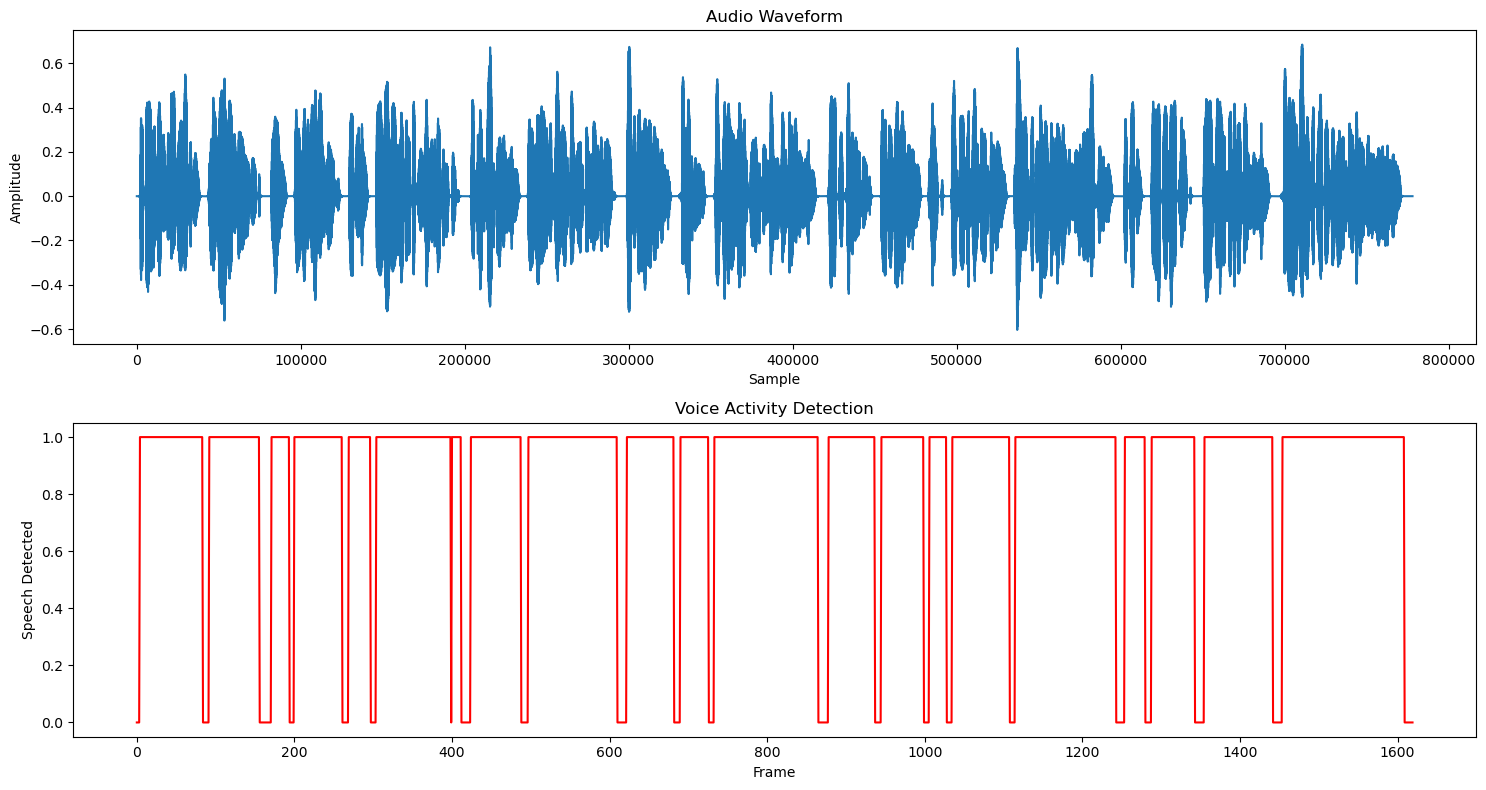

In [6]:
def test_vad(audio_data, sample_rate=16000, frame_duration=30):
    """
    Test Voice Activity Detection on audio data.
    """
    vad = webrtcvad.Vad(3)
    frame_length = int(sample_rate * (frame_duration / 1000.0))
    frames = []
    speech_frames = []

    for i in range(0, len(audio_data) - frame_length, frame_length):
        frame = audio_data[i:i + frame_length]
        frame_bytes = (frame * 32767).astype(np.int16).tobytes()
        frames.append(frame)
        speech_frames.append(vad.is_speech(frame_bytes, sample_rate))

    return frames, speech_frames

# Test VAD
frames, speech_frames = test_vad(test_audio)

# Visualize VAD results
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(test_audio)
plt.title('Audio Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(speech_frames, 'r')
plt.title('Voice Activity Detection')
plt.xlabel('Frame')
plt.ylabel('Speech Detected')

plt.tight_layout()
plt.show()

# Audio Processor Class

In [12]:
class AudioProcessor:
    def __init__(
        self,
        sample_rate: int = 16000,
        chunk_duration_ms: int = 30,
        padding_duration_ms: int = 300,
        silence_threshold: float = 0.01,
        min_speech_duration_ms: int = 500,
        max_silence_duration_ms: int = 1000,
        model_size: str = "base",
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
        compute_type: str = "float16" if torch.cuda.is_available() else "int8"
    ):
        self.sample_rate = sample_rate
        self.chunk_duration_ms = chunk_duration_ms
        self.padding_duration_ms = padding_duration_ms
        self.silence_threshold = silence_threshold
        self.min_speech_duration_ms = min_speech_duration_ms
        self.max_silence_duration_ms = max_silence_duration_ms

        # Initialize VAD (Voice Activity Detection)
        self.vad = webrtcvad.Vad(3)  # Aggressiveness level 3

        # Initialize faster-whisper
        self.model = WhisperModel(
            model_size_or_path=model_size,
            device=device,
            compute_type=compute_type
        )

        # Buffer for collecting audio chunks
        self.audio_buffer = deque()
        self.current_transcript = ""
        self.silence_start = None
        self.is_speaking = False

        # Keep track of partial transcripts
        self.partial_transcripts = []

    def _decode_audio(self, base64_audio: str) -> np.ndarray:
        """Decode base64 audio data to numpy array."""
        audio_bytes = base64.b64decode(base64_audio)
        audio_array = np.frombuffer(audio_bytes, dtype=np.float32)
        return audio_array

    def _is_silence(self, audio_chunk: np.ndarray) -> bool:
        """Check if an audio chunk is silence."""
        return np.max(np.abs(audio_chunk)) < self.silence_threshold

    def process_audio_chunk(self, event_data: Dict) -> Optional[Dict]:
        """Process incoming audio chunk and determine if response is needed."""
        audio_data = self._decode_audio(event_data["audio"])
        self.audio_buffer.append(audio_data)

        # Check for voice activity
        is_speech = self.vad.is_speech(
            audio_data.tobytes(),
            sample_rate=self.sample_rate
        )

        if is_speech and not self.is_speaking:
            self.is_speaking = True
            self.silence_start = None
        elif not is_speech and self.is_speaking:
            if self.silence_start is None:
                self.silence_start = 0
            else:
                silence_duration = len(self.audio_buffer) * self.chunk_duration_ms
                if silence_duration >= self.max_silence_duration_ms:
                    return self._process_completed_utterance()

        # Periodically transcribe accumulated audio for partial results
        if len(self.audio_buffer) * self.chunk_duration_ms >= 500:  # Every 500ms
            self._update_partial_transcript()

        return None

    def _update_partial_transcript(self):
        """Update partial transcription of current audio buffer."""
        if len(self.audio_buffer) > 0:
            audio = np.concatenate(list(self.audio_buffer))
            segments, _ = self.model.transcribe(
                audio,
                beam_size=5,
                word_timestamps=True,
                condition_on_previous_text=True if self.partial_transcripts else False,
                initial_prompt=self.partial_transcripts[-1] if self.partial_transcripts else None
            )

            transcript = " ".join(segment.text for segment in segments)
            if transcript.strip():
                self.partial_transcripts.append(transcript)

    def _process_completed_utterance(self) -> Optional[Dict]:
        """Process completed utterance and determine if response is needed."""
        # Combine audio chunks
        full_audio = np.concatenate(list(self.audio_buffer))

        # Transcribe audio with faster-whisper
        segments, info = self.model.transcribe(
            full_audio,
            beam_size=5,
            word_timestamps=True,
            condition_on_previous_text=True if self.partial_transcripts else False,
            initial_prompt=self.partial_transcripts[-1] if self.partial_transcripts else None
        )

        transcription = " ".join(segment.text for segment in segments)
        self.current_transcript = transcription

        # Clear buffer and reset states
        self.audio_buffer.clear()
        self.is_speaking = False
        self.silence_start = None
        self.partial_transcripts = []

        # Check if response is needed
        if self._should_respond(transcription):
            return {
                "should_respond": True,
                "transcript": transcription,
                "language": info.language,
                "language_probability": info.language_probability
            }
        return None

    def _should_respond(self, transcript: str) -> bool:
        """Determine if the transcript warrants a response."""
        # Basic heuristics for detecting questions or commands
        question_indicators = ["?", "what", "how", "when", "where", "why", "can you", "could you"]
        command_indicators = ["please", "help", "tell me", "show me", "explain"]

        transcript_lower = transcript.lower()

        # Check for questions
        if any(indicator in transcript_lower for indicator in question_indicators):
            return True

        # Check for commands
        if any(indicator in transcript_lower for indicator in command_indicators):
            return True

        # Check for complete sentences
        if transcript.strip().endswith((".", "!", "?")):
            return True

        return False



## 3. Test Faster Whisper Transcription

In [7]:
import torch
print("Is Cuda available {}".format(torch.cuda.is_available()))

Is Cuda available False


In [8]:
def test_transcription(audio_data, sample_rate=16000):
    """
    Test faster-whisper transcription.
    """
    # Initialize model
    model = WhisperModel(
        model_size_or_path='base',
        device="cuda" if torch.cuda.is_available() else "cpu",
        compute_type="float16" if torch.cuda.is_available() else "int8"
    )

    # Transcribe
    segments, info = model.transcribe(
        audio_data,
        beam_size=5,
        word_timestamps=True,
        vad_filter=True,
        vad_parameters=dict(min_silence_duration_ms=500),
    )

    return segments, info

# Test transcription
segments, info = test_transcription(test_audio)

print("Transcription Results:")
print(f"Detected language: {info.language} (probability: {info.language_probability:.2f})\n")

for segment in segments:
    print(f"[{segment.start:.1f}s -> {segment.end:.1f}s] {segment.text}")

Transcription Results:
Detected language: en (probability: 0.96)

[0.0s -> 7.4s]  Technology is evolving rapidly, shaping the way we communicate, learn, and entertain ourselves.
[8.1s -> 14.4s]  Every day, new innovations make it easier to stay connected, access vast information,
[14.9s -> 21.5s]  and engage with diverse cultures from around the globe. Artificial intelligence, for instance,
[21.9s -> 27.5s]  has revolutionized industries by enhancing automation, predictive capabilities,
[27.5s -> 35.1s]  and personalization, yet, as these advancements continue, they raise ethical and social
[35.1s -> 42.9s]  considerations about privacy, equity, and the future of work. In this era of digital transformation,
[42.9s -> 48.0s]  finding a balance between progress and responsibility remains essential.


Numpy audio data back to audio 

In [ ]:
def audio_data_to_file(audio_data, output_format="mp3"):
    """
    Convert NumPy array audio data back to a playable audio format.
    
    Parameters:
    - audio_data: The normalized NumPy array of audio samples.
    - output_format: The desired output format (e.g., 'mp3', 'wav').

    Returns:
    - audio_bytes: A BytesIO object containing the audio data in the desired format.
    """
    # Convert the NumPy array back to integer values
    int_audio_data = (audio_data * 32768).astype(np.int16)

    # Create an AudioSegment from raw audio data
    audio_segment = AudioSegment(
        data=int_audio_data.tobytes(),
        sample_width=2,  # 16-bit audio
        frame_rate=16000,  # Sample rate used in original function
        channels=1  # Mono audio
    )

    # Save the AudioSegment to a BytesIO object
    audio_bytes = io.BytesIO()
    audio_segment.export(audio_bytes, format=output_format)
    audio_bytes.seek(0)
    
    return audio_bytes

## 4. Test Complete Pipeline

In [ ]:
def test_complete_pipeline(audio_data, chunk_size_ms=30):
    """
    Test the complete audio processing pipeline.
    """
    processor = AudioProcessor()

    # Split audio into chunks
    chunk_size = int(16000 * (chunk_size_ms / 1000.0))
    chunks = [audio_data[i:i + chunk_size] for i in range(0, len(audio_data), chunk_size)]

    results = []
    for i, chunk in enumerate(chunks):
        # Create mock event data
        event_data = {
            "event_id": f"event_{i}",
            "type": "input_audio_buffer.append",
            "audio": audio_data_to_file(chunk)
        }

        result = processor.process_audio_chunk(event_data)
        if result:
            results.append(result)

    return results

# Test complete pipeline
pipeline_results = test_complete_pipeline(test_audio)

print("Pipeline Results:")
for i, result in enumerate(pipeline_results):
    print(f"\nResult {i+1}:")
    print(f"Transcript: {result['transcript']}")
    print(f"Language: {result['language']} (probability: {result['language_probability']:.2f})")
    print(f"Should respond: {result['should_respond']}")

In [ ]:
from transformers import pipeline

# Load a small model for question or response classification
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

def should_respond(text):
    """
    Determine if the model should respond based on the input text.
    Uses a small NLP model to classify if it's a response-worthy phrase.
    """
    response_keywords = ["hello", "help", "can you", "please", "how are", "question"]
    
    # Check if any keywords are present
    if any(keyword in text.lower() for keyword in response_keywords):
        return True
    
    # Use the classifier to see if the input resembles a question or request
    prediction = classifier(text)[0]
    
    # Consider labels like "POSITIVE" as response-worthy
    if prediction["label"] == "POSITIVE" and prediction["score"] > 0.8:
        return True
    else:
        return False

# Test with some example input
input_text = "Hello, can you help me?"
print(f"Should respond: {should_respond(input_text)}")

## 5. Simulate WebSocket Connection

In [ ]:
async def simulate_websocket_stream(audio_data, chunk_size_ms=30):
    """
    Simulate streaming audio over WebSocket.
    """
    chunk_size = int(16000 * (chunk_size_ms / 1000.0))
    chunks = [audio_data[i:i + chunk_size] for i in range(0, len(audio_data), chunk_size)]

    session = AudioChatSession()

    class MockWebSocket:
        async def send(self, message):
            print(f"Received response: {message}")

    mock_ws = MockWebSocket()

    for i, chunk in enumerate(chunks):
        event_data = {
            "event_id": f"event_{i}",
            "type": "input_audio_buffer.append",
            "audio": encode_audio(chunk)
        }

        await session.handle_audio_message(mock_ws, event_data)
        await asyncio.sleep(chunk_size_ms / 1000.0)  # Simulate real-time

# Test WebSocket simulation
await simulate_websocket_stream(test_audio)

## 6. Performance Metrics

In [ ]:
def measure_performance(audio_data, num_runs=5):
    """
    Measure performance metrics of the system.
    """
    processor = AudioProcessor()

    timings = {
        'vad': [],
        'transcription': [],
        'total': []
    }

    for _ in range(num_runs):
        start_total = time.time()

        # Test VAD
        start = time.time()
        frames, speech_frames = test_vad(audio_data)
        timings['vad'].append(time.time() - start)

        # Test transcription
        start = time.time()
        segments, info = test_transcription(audio_data)
        timings['transcription'].append(time.time() - start)

        timings['total'].append(time.time() - start_total)

    print("Performance Metrics (averaged over {num_runs} runs):")
    for key, values in timings.items():
        avg_time = sum(values) / len(values)
        print(f"{key.capitalize()} processing time: {avg_time:.3f}s")

# Measure performance
measure_performance(test_audio)